## Imports

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import log_loss, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score


from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy as np

from tabulate import tabulate


# rating_mapping = {"-":0,
#     "AAA": 1, "AA+": 2, "AA": 3, "AA-": 4,
#     "A+": 5, "A": 6, "A-": 7,
#     "BBB+": 8, "BBB": 9, "BBB-": 10,
#     "BB+": 11, "BB": 12, "BB-": 13,
#     "B+": 14, "B": 15, "B-": 16,
#     "CCC+": 17, "CCC": 18, "CCC-": 19,
#     "CC": 20, "C": 21, "D": 22
# }


In [13]:
data = pd.read_csv("new_regression_ready_clean.csv")
# data['S&P Rating'] = data['sp_rating'].map(rating_mapping)
data = data.replace({',': ''}, regex=True)
data = data.apply(pd.to_numeric, errors='coerce')
data = data.fillna(0)  # Drops rows with NaN values; you can also use .fillna() if preferred


print(tabulate(data.head(5), headers='keys', tablefmt='psql'))


+----+----------+-------------+-----------------+---------------+-------------------+------------------+--------------------+--------------+--------------------+--------------------+---------------------+--------------------+-------------------+--------------------+--------------------+--------------+--------------+------------------+--------------+-----------------+-------------+---------------------+-----------------+----------------------+-----------------+----------------------+-------------------+------------------+---------------+----------------+----------------------+---------------------+---------------------------+--------------------+-------------------------------+---------------------+------------------+---------------------+---------------------+----------------+---------------------+---------------+----------------+----------------------+------------------+--------------------------+-----------------+-----------------------+-----------------------+-----------------------

In [12]:
# for column_name in data.columns:
#     print(f'{column_name}: {data[column_name].apply(type).value_counts()}')

In [48]:
for i in np.logspace(-3, 3, num=10):
    print(i)

0.001
0.004641588833612777
0.021544346900318832
0.1
0.46415888336127775
2.154434690031882
10.0
46.41588833612773
215.44346900318823
1000.0


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Accuracy: 0.603448275862069
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.49      0.53       742
           1       0.62      0.70      0.66       882

    accuracy                           0.60      1624
   macro avg       0.60      0.59      0.59      1624
weighted avg       0.60      0.60      0.60      1624



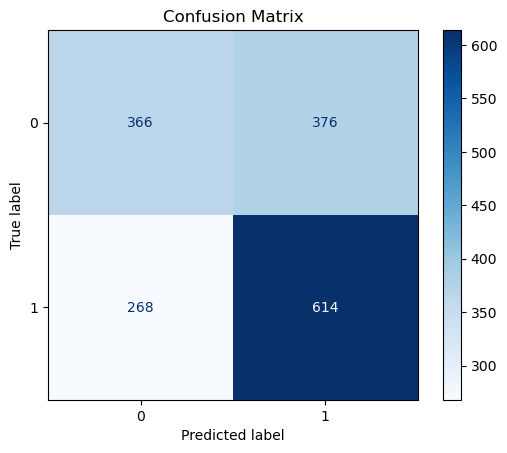

In [52]:
# Separate features and target variable
X = data.iloc[:, 3:]  # all columns except the first one
y = data.iloc[:, 0]   # the first column

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Initialize and train the logistic regression model
model = LogisticRegression(max_iter=1000)



param_grid = {
       'C': np.logspace(-3, 3, num=10),
       'penalty': ['l1', 'l2'],  # Note: 'l1' requires solver 'liblinear'
       'solver': ['liblinear'],
 # You can also include other solvers like 'saga' if using 'l2'
   }
scoring = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                              scoring='accuracy', cv=5, verbose=1)


grid_search_ll = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=5)



grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

grid_search_ll.fit(X_train, y_train)
best_model_ll = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [50]:
results = pd.DataFrame(grid_search.cv_results_)
print(tabulate(results.head(), headers='keys', tablefmt='psql'))
results_ll = pd.DataFrame(grid_search_ll.cv_results_)
print(tabulate(results_ll.head(20), headers='keys', tablefmt='psql'))

+----+-----------------+----------------+-------------------+------------------+------------+-----------------+----------------+---------------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|    |   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time |    param_C | param_penalty   | param_solver   | params                                                              |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|----+-----------------+----------------+-------------------+------------------+------------+-----------------+----------------+---------------------------------------------------------------------+---------------------+---------------------+---------------------+

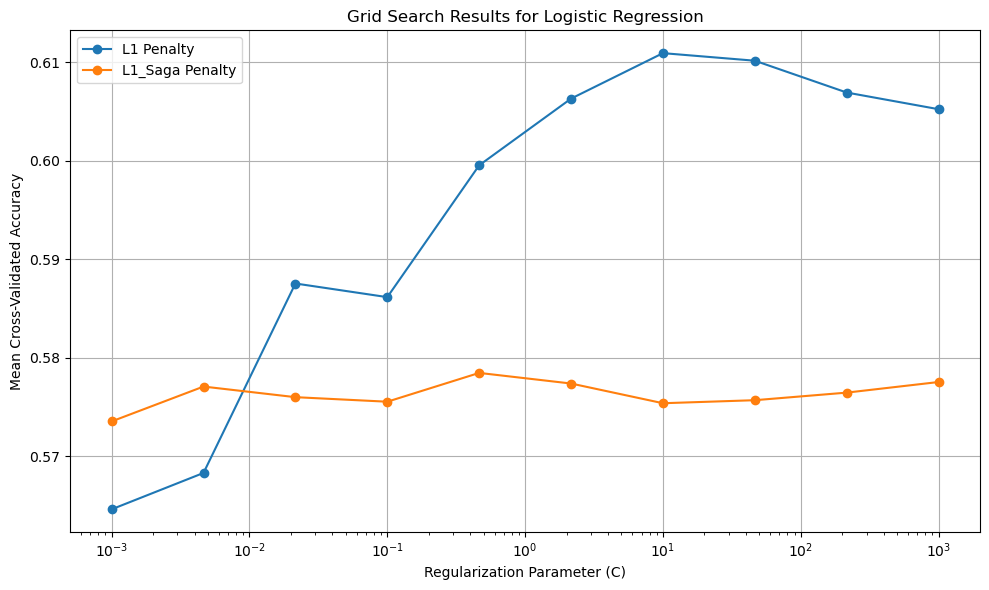

In [44]:
results = pd.DataFrame(grid_search.cv_results_)
# results = results.apply(pd.to_numeric, errors='coerce')

# Filter results for plotting
results_l1 = results[(results['param_penalty'] == 'l1') & (results['param_solver'] == 'liblinear')]
results_l2 = results[(results['param_penalty'] == 'l2') & (results['param_solver'] == 'liblinear')]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results_l1['param_C'], results_l1['mean_test_score'], marker='o', label='L1 Penalty', linestyle='-')
plt.plot(results_l2['param_C'], results_l2['mean_test_score'], marker='o', label='L1_Saga Penalty', linestyle='-')

# Adding labels and title
plt.xscale('log')  # Log scale for better visibility
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean Cross-Validated Accuracy')
plt.title('Grid Search Results for Logistic Regression')
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

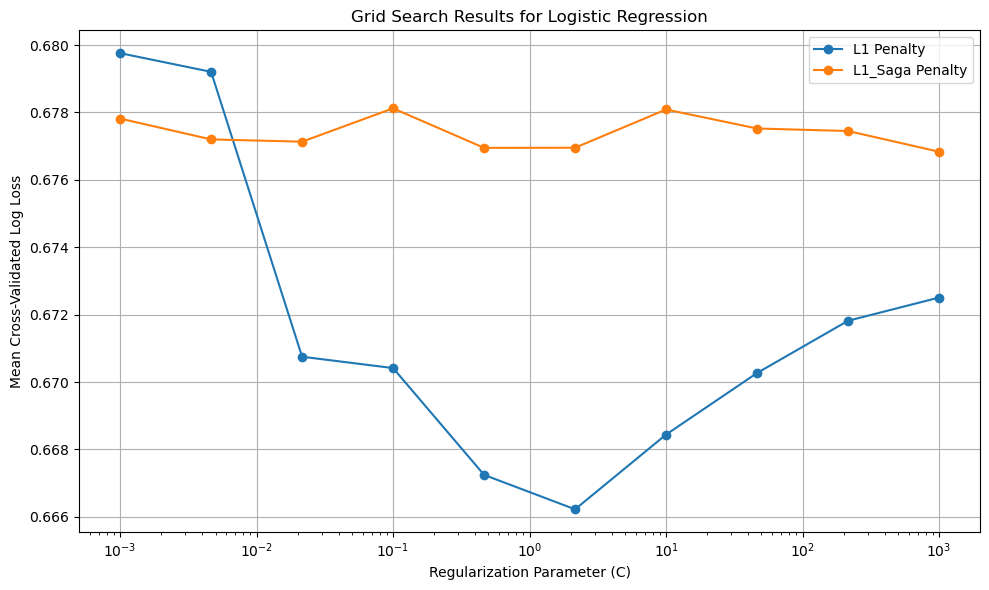

In [47]:
results_ll = pd.DataFrame(grid_search_ll.cv_results_)
# results = results.apply(pd.to_numeric, errors='coerce')

# Filter results for plotting
results_l1_ll = results_ll[(results_ll['param_penalty'] == 'l1') & (results_ll['param_solver'] == 'liblinear')]
results_l2_ll = results_ll[(results_ll['param_penalty'] == 'l2') & (results_ll['param_solver'] == 'liblinear')]


# Plotting
plt.figure(figsize=(10, 6))

# Plot for 'l1' penalty
plt.plot(results_l1_ll['param_C'], [-1*(ll) for ll in results_l1_ll['mean_test_score']], marker='o', label='L1 Penalty', linestyle='-')
# Plot for 'l2' penalty

plt.plot(results_l2_ll['param_C'], [-1*(ll) for ll in results_l2_ll['mean_test_score']], marker='o', label='L1_Saga Penalty', linestyle='-')

# Adding labels and title
plt.xscale('log')  # Log scale for better visibility
plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Mean Cross-Validated Log Loss')
plt.title('Grid Search Results for Logistic Regression')
# plt.xticks(ticks=results['param_C'], labels=results['param_C'], rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

# Show the plot
plt.show()

In [45]:
print(tabulate(results_ll.head(), headers='keys', tablefmt='psql'))


+----+-----------------+----------------+-------------------+------------------+------------+-----------------+----------------+---------------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|    |   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time |    param_C | param_penalty   | param_solver   | params                                                              |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|----+-----------------+----------------+-------------------+------------------+------------+-----------------+----------------+---------------------------------------------------------------------+---------------------+---------------------+---------------------+

AUC: 0.6326


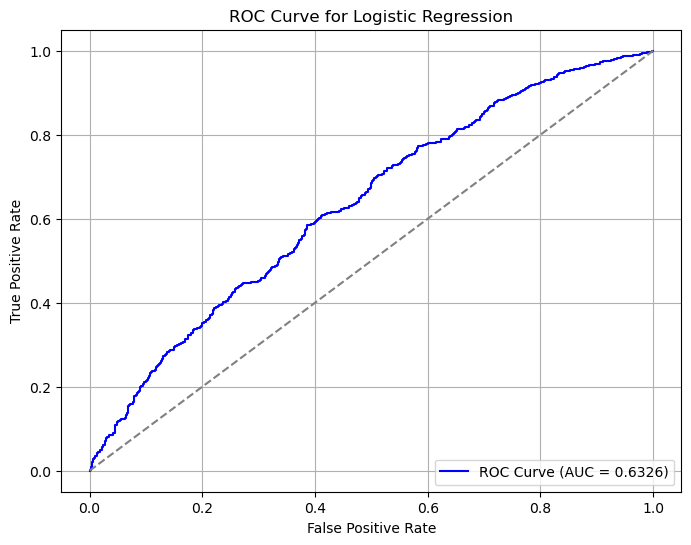

In [55]:
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Step 3: Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Step 4: Calculate the AUC
auc = roc_auc_score(y_test, y_prob)
print(f"AUC: {auc:.4f}")

# Step 5: Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random guess line
plt.title("ROC Curve for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [35]:
print(results_l2_saga['mean_test_score'])
print(results_l1_saga['mean_test_score'])

3     0.534719
7     0.534719
11    0.534719
15    0.534719
19    0.534719
23    0.534719
27    0.534719
31    0.534719
35    0.534719
39    0.534719
Name: mean_test_score, dtype: float64
1     0.534719
5     0.534719
9     0.534719
13    0.534719
17    0.534719
21    0.534719
25    0.534719
29    0.534719
33    0.534719
37    0.534719
Name: mean_test_score, dtype: float64


In [44]:
# for key, value in results.items():
#     print(f'key:{key}, value:{value}')

# for key, value in results.items():
#     print(f'key:{key}')

print()
print(tabulate(results[results['param_penalty'] == 'l2'],headers='keys', tablefmt='psql'))



+----+-----------------+----------------+-------------------+------------------+-----------+------------------+-----------------+----------------+-----------------------------------------------------------------------+---------------------+---------------------+---------------------+---------------------+---------------------+-------------------+------------------+-------------------+
|    |   mean_fit_time |   std_fit_time |   mean_score_time |   std_score_time |   param_C |   param_max_iter | param_penalty   | param_solver   | params                                                                |   split0_test_score |   split1_test_score |   split2_test_score |   split3_test_score |   split4_test_score |   mean_test_score |   std_test_score |   rank_test_score |
|----+-----------------+----------------+-------------------+------------------+-----------+------------------+-----------------+----------------+-----------------------------------------------------------------------+-----